<a href="https://colab.research.google.com/github/vladoxNCL/Conway_Life/blob/main/fair_kruskal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and constants

In [ ]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import random as rd

node_colors = {
    'f': 'red',
    'u': 'blue',
}

edge_colors = {
    'ff': 'red',
    'uu': 'blue',
    'uf': 'green',
}

seed = 42

## Functions

In [129]:
def gen_pa_graph(n=20, p=0.15, pu=0.6, w_min=1, w_max=10, seed=None):
    """
    Args:
        n     : number of nodes
        p     : edge probability
        pu    : unfavoured node probability
        w_min : minimum edge weight
        w_max : maximum edge weight
        seed  : random seed

    Returns:
        C     : connected random graph with node PAs and weighted edges
    """
    # Set random seed
    rd.seed(seed)

    # generate graph and keep largest component
    G = nx.erdos_renyi_graph(n, p, seed=seed)
    cc = max(nx.connected_components(G))
    C = G.subgraph(cc)
    k =C.number_of_nodes()

    # generate pas: {u, f} with probas pu and 1 - pu
    pas = rd.choices(['u', 'f'], weights=[pu, 1 - pu], k=k)
    for i, n in enumerate(C.nodes):
        C.nodes[n]['pa'] = pas[i]

    # generate weights for edges
    weights = {e: rd.randint(w_min, w_max) for e in C.edges}

    # assign labels to edges: {uu, uf, ff} and weights [1..10]
    for e in C.edges:
        start = C.nodes[e[0]]['pa']
        end = C.nodes[e[1]]['pa']
        epa = f'{start}{end}' if start == end else 'uf'
        C.edges[e]['epa'] = epa
        C.edges[e]['weight'] = weights[e]

    return C

def fair_kruskal(G, strat='p_fixed', seed=None):
    """
    Arg:
        G : weighted and PA labelled graph

    Returns:
        T : fair minimum spanning tree
    """
    # Set random seed
    rd.seed(seed)

    # categorise edges and keep weights
    epa = nx.get_edge_attributes(G, 'epa')
    epa_unique = list(set(epa.values()))
    epas = {
        u: [e for e in epa if epa[e] == u]
        for u in epa_unique
    }
    weights = nx.get_edge_attributes(G, 'weight')

    # copy graph nodes
    T = nx.Graph()
    T.add_nodes_from(G.nodes(data=True))

    # init weight probabilities
    ws = [len(epas[u]) for u in epa_unique]

    # stop condition for tree
    while len(T.edges) < len(T.nodes) - 1:

        match strat:
            case 'p_fixed':
                # keep fixed probabilities from start
                u = rd.choices(epa_unique, weights=ws, k=1)[0]
            case 'p_dynamic':
                # adjust probability after each edge addition
                ws = [len(epas[u]) for u in epa_unique]
                u = rd.choices(epa_unique, weights=ws, k=1)[0]
            case 'minority':
                # choose least represented edge type in T
                T_count = {
                    u: list(
                        nx.get_edge_attributes(T, 'epa').values()
                    ).count(u)
                    for u in epa_unique if len(epas[u]) > 0
                }
                least_rep = [
                    k for k, v in T_count.items() if v == min(T_count.values())
                ]
                u = rd.choice(least_rep)
            case 'p_weights':
                # edge weights are multiplied by their class count in T (+ 1)
                T_count = {
                    u: list(
                        nx.get_edge_attributes(T, 'epa').values()
                    ).count(u) + 1
                    for u in epa_unique
                }
                p_weights = {
                    e: weights[e] * T_count[u]
                    for u in epa_unique for e in epas[u]
                }
                lpw = [
                    e for e, w in p_weights.items()
                    if w == min(p_weights.values())
                ]
                e = rd.choice(lpw)
                u = epa[e]

        if not strat == 'p_weights':
            # get weights for the relevant edges and sort by weight
            u_weights = {e: weights[e] for e in epas[u]}
            # get the edge with the smallest weight
            e = sorted(
                u_weights.items(), key=lambda item: item[1]
            )[0][0] if u_weights else None

        if e:
            # add edge if it doesn't form a cycle
            if not nx.has_path(T, *e):
                T.add_edge(*e)
                T.edges[e]['epa'] = epa[e]
                T.edges[e]['weight'] = weights[e]

            # remove edge from edges to consider
            epas[u].remove(e)

    return T

def graph_stats(G, orig=None, print_stats=False):
    """
    Args:
        G           : graph
        print_stats : print stats

    Returns:
        stats       : graph's weight sum and edge diversity
    """
    # split edges by edge pa class
    epa = nx.get_edge_attributes(G, 'epa')
    epa_u = list(set(epa.values()))
    epas = {
        u: [e for e in epa if epa[e] == u] for u in epa_u
    }
    n_edges = G.number_of_edges()

    # sum of weights
    w_sum = sum(nx.get_edge_attributes(G, 'weight').values())

    # edge representation
    e_rep = {
        u: {
            'total': len(epas[u]),
            'p': len(epas[u]) / n_edges,
        } for u in epa_u
    }

    # edge diversity
    reps = [e_rep[u]['p'] for u in e_rep]
    norm_ent = - sum([r * math.log(r) for r in reps]) / math.log(len(reps))
    gini = sum([r * (1 - r) for r in reps])
    imb_ratio = max(reps) / min(reps)

    # proportion similarity with original
    if orig:
        orig_epa = nx.get_edge_attributes(orig, 'epa')
        orig_epa_u = list(set(orig_epa.values()))
        orig_epas = {
            u: [e for e in orig_epa if orig_epa[e] == u]
            for u in orig_epa_u
        }
        orig_props = {
            u: len(orig_epas[u]) / len(orig_epa)
            for u in orig_epa_u
        }
        prop_dif = 1 - sum([
            abs(e_rep[u]['p'] - orig_props[u])
            for u in e_rep
        ])
    else:
        prop_dif = None

    # stats dictionary
    stats = {
        'ws': w_sum,
        'er': e_rep,
        'ne': norm_ent,
        'gi': gini,
        'ir': imb_ratio,
        'pd': prop_dif,
    }

    if print_stats:
        print('-' * 21)
        print(f'Weight Sum\t{w_sum:>5}')
        print('Edge Proportions')
        for e in e_rep:
            print(
                f' {e}\t\t{e_rep[e]["p"]:.3f}'
            )
        print(f'Norm Entropy\t{norm_ent:.3f}')
        print(f'Gini Index\t{gini:.3f}')
        print(f'Imb Ratio\t{imb_ratio:.3f}')
        if prop_dif:
            print(f'Prop Sim\t{prop_dif:.3f}')
        print('-' * 21)

    return stats

def draw_graph(G, seed=None, ax=None):
    """
    Arg:
        G : graph with PA and EPA labels

    Returns:
        None
    """
    e_colors = [edge_colors[G.edges[e]['epa']] for e in G.edges]
    n_colors = [node_colors[G.nodes[n]['pa']] for n in G.nodes]

    # place the nodes the same way
    pos = nx.spring_layout(G, seed=seed)

    nx.draw(
        G, with_labels=True, pos=pos,
        font_color='w',
        edge_color=e_colors, width=2,
        node_color=n_colors,
        ax=ax,
    )

## Sample graphs

---------------------
Weight Sum	  149
Edge Proportions
 ff		0.107
 uf		0.357
 uu		0.536
Norm Entropy	0.857
Gini Index	0.574
Imb Ratio	5.000
---------------------


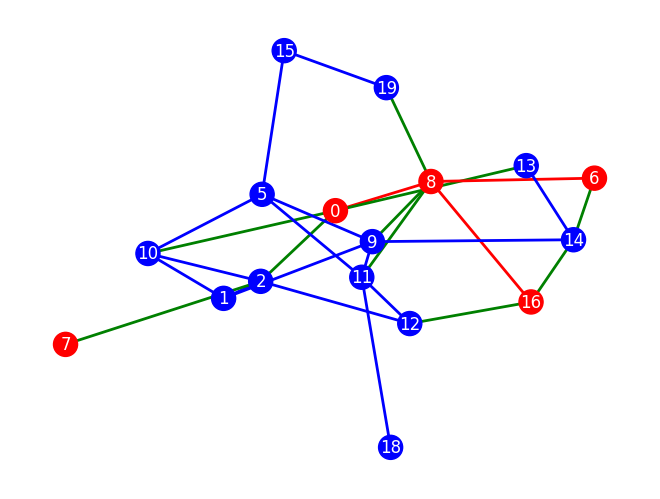

In [130]:
# connected graph
seed = 42
C = gen_pa_graph(seed=seed)
graph_stats(C, print_stats=True)
draw_graph(C, seed=seed)

In [131]:
seed = 54321
trees = {}
strats = {
    'p_fixed': 'Fixed Probability',
    'p_dynamic': 'Dynamic Probability',
    'minority': 'Minority Preference',
    'p_weights': 'Proportional Weights',
}
for s in strats:
    T = fair_kruskal(C, strat=s, seed=seed)
    print(f'\n{strats[s]}')
    graph_stats(T, orig=C, print_stats=True)
    trees[s] = T


Fixed Probability
---------------------
Weight Sum	   60
Edge Proportions
 ff		0.125
 uf		0.438
 uu		0.438
Norm Entropy	0.895
Gini Index	0.602
Imb Ratio	3.500
Prop Sim	0.804
---------------------

Dynamic Probability
---------------------
Weight Sum	   57
Edge Proportions
 ff		0.125
 uf		0.375
 uu		0.500
Norm Entropy	0.887
Gini Index	0.594
Imb Ratio	4.000
Prop Sim	0.929
---------------------

Minority Preference
---------------------
Weight Sum	   60
Edge Proportions
 ff		0.188
 uf		0.375
 uu		0.438
Norm Entropy	0.950
Gini Index	0.633
Imb Ratio	2.333
Prop Sim	0.804
---------------------

Proportional Weights
---------------------
Weight Sum	   57
Edge Proportions
 ff		0.188
 uf		0.312
 uu		0.500
Norm Entropy	0.932
Gini Index	0.617
Imb Ratio	2.667
Prop Sim	0.839
---------------------


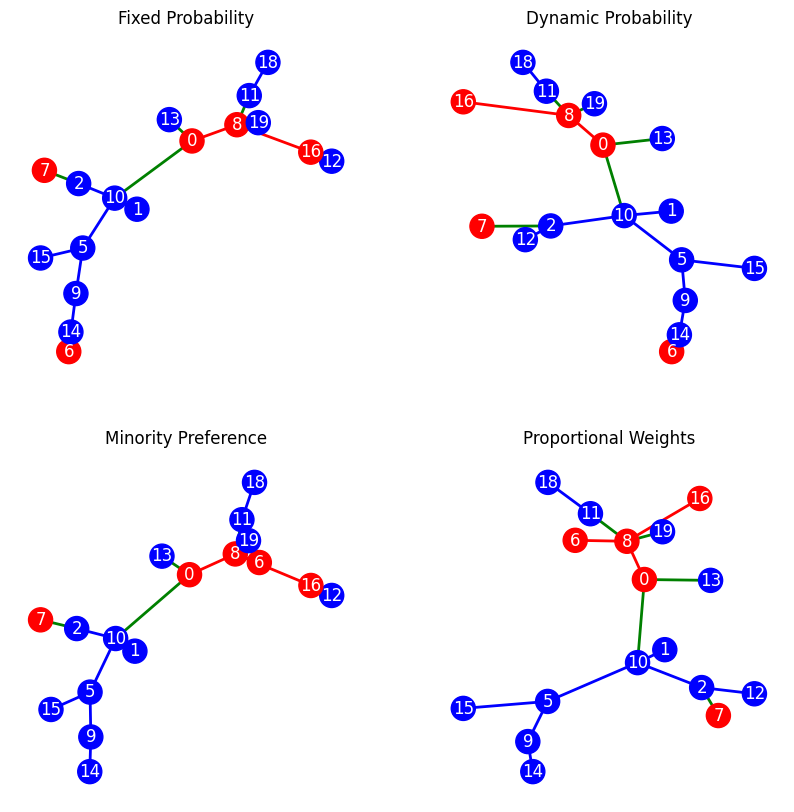

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for s, ax in zip(strats, axs.flat):
    draw_graph(trees[s], seed=seed, ax=ax)
    ax.set_title(f'{strats[s]}')

# TO DO
- Design / run / analyse experiments
- Alternative fairness definitions
- Assign PAs to edges directly? (only U and F)
- More alternatives to adding labels to tree

[Nice Google page with diversity metrics](https://pair.withgoogle.com/explorables/measuring-diversity/)

## Metrics considered so far:
- Normalised Shannon Entropy (0 -> no diversity, 1 -> high diversity)
$$
    \mathit{NE}(G) = \frac{- \sum_{c \in C} p_c \log(p_c)}{\log(|C|)}
$$
- Gini Index (0 -> no diversity, 1 -> high diversity)
$$
    \mathit{Gini}(G) = \sum_{c \in C}^n p_c (1 - p_c)
$$
- Imbalance Ratio (close to 1 -> more balanced)
$$
    \mathit{IR}(G) = \frac{\max_{c \in C} p_c}{\min_{c \in C} p_c}
$$

where $C = \{\texttt{uu}, \texttt{ff}, \texttt{uf}\}$, and $p_c$ is the proportion of $c$ in $G$.
